<a href="https://colab.research.google.com/github/Igor-Basilio/Principios-de-Comm/blob/main/Atividade_1_Modula%C3%A7%C3%A3o_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Princípios de Comunicação
## Atividade Computacional 1 - Modulação AM

Esta atividade irá explorar os conceitos da modulação em amplitude (AM). Será apresentada uma simulação do processo de modulação AM-DSB-SC e da demodulação síncrona como exemplo. A atividade computacional consistirá na simulação da modulação AM-DSB e por detecção de envoltória.

Serão utilizadas algumas bibliotecas do python, de forma a facilidar cada etapa.

Bibliotecas:

*   librosa - Manipulação de arquivos de áudio
*   numpy - Obtenção da Transformada Discreta de Fourier usando o algoritmo FFT
*   scipy - Filtragem de sinais com filtros do tipo butterworth
*   matplotlib - Gráficos


In [2]:
import librosa
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import hilbert, envelope

**Adquirindo um sinal de áudio para transmissão**

A aquisição de sinais de áudio diretamente no colab é difícil, já que o código será executado em uma máquina virtual. Por isso, se quiser utilizar um sinal de áudio gravado, é necessário adquirir ele usando um software de gravação de áudio, e posteriormente carregar o sinal no colab.

Para esta demonstração, utilizaremos trechos de áudios disponíveis na biblioteca librosa. Para simplificar o processamento, os arquivos de áudio serão cortados, fazendo com que todos sinais tenham uma mesma duração (5 segundos).

In [ ]:
# Endereço do arquivo de áudio
caminho_arquivo = librosa.ex('brahms')
# Leitura do arquivo como um array numpy considerando a taxa de amostragem original do arquivo
array_audio_1, taxa_amostragem_1 = librosa.load(caminho_arquivo, sr=None)

# Retirando um trecho de 5 segundos do áudio
amostras_5s = 5 * taxa_amostragem_1
array_audio_1_cortado=array_audio_1[0:amostras_5s]

# Executando o sinal de áudio
Audio(data=array_audio_1_cortado, rate=taxa_amostragem_1)

Como os sinais de áudio podem ser adquiridos utilizando frequências de amostragem distintas, iremos reamostrar o sinal para uma frequência de subamostragem (10 kHz), a qual é menor do que a original.

Para realizarmos a simulação do processo de modulação, o qual geralmente é realizado utilizando equipamentos em tempo contínuo, é necessário trabalhar com os sinais em uma frequência muito maior que a frequência dos sinais, de forma a garantir que os procedimentos se aproximem melhor do equivalente em tempo contínuo. Para isso, utilizaremos uma frequência de superamostragem (1 MHz). Dessa forma, o sinal de áudio que contém informações até 10 kHz será superamostrado, contendo amostras em uma frequência de 1 MHz, porém, com informações limitadas ao espectro original.  

In [ ]:
# Definindo a frequência de amostragem para simular a trasmissão como se tivessemos usando um sistema contínuo
freq_superamostragem = 1e6
freq_subamostragem = 1e4

array_audio_1_subamostrado = librosa.resample(array_audio_1_cortado, orig_sr=taxa_amostragem_1, target_sr=freq_subamostragem)
# Reamostrando o áudio para a frequência mais alta
array_audio_1_superamostrado = librosa.resample(array_audio_1_subamostrado, orig_sr=freq_subamostragem, target_sr=freq_superamostragem)

Nesta etapa iremos realizar a modulação utilizando a técnica AM-DSB-SC. Este tipo de modulação é representado pela equação

$$\Phi_{AM-DSB-SC}(t)=m(t)cos(\omega_c t)$$.

Para realizarmos esse processo, iremos criar uma portadora com frequência 50 kHz, criando um eixo de tempo, com o mesmo número de elementos da mensagem, e valores condizentes com os intantes de tempo da mensagem. Com essa portadora, podemos realizar a modulação multiplicando cada amostra da mensagem pela amostra correspondente da portadora.

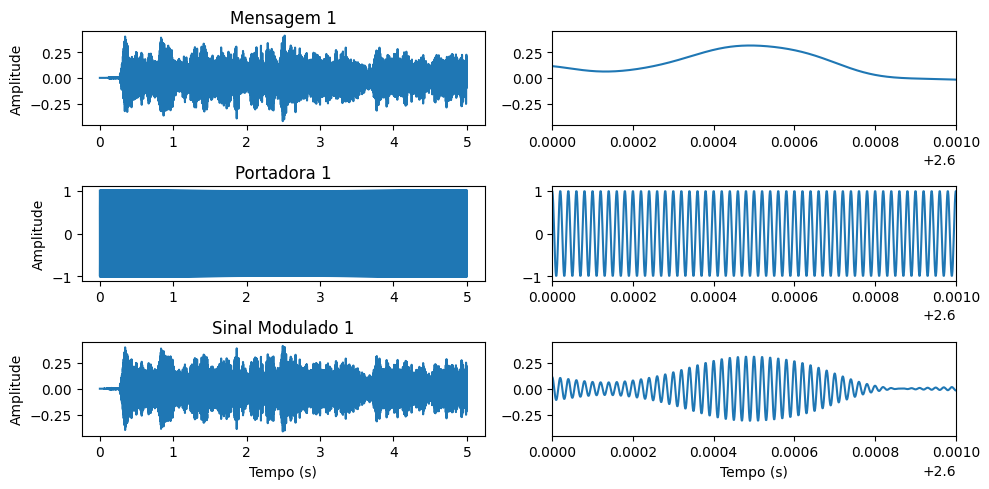

In [ ]:
# Frequência da portadora da rádio 1 [Hz]
fc1 = 5e4

# Criando a portadora 1
eixo_t=np.linspace(0, 5, len(array_audio_1_superamostrado))
portadora_1=np.zeros([len(array_audio_1_superamostrado)])

for i in range(0,len(array_audio_1_superamostrado)):
    portadora_1[i]=np.cos(2*np.pi*fc1*eixo_t[i])

# Realizando a modulação
mensagem_1_modulada=array_audio_1_superamostrado*portadora_1

# Plotando o sinal de áudio
plt.figure(figsize = (10, 5))
plt.subplot(3,2,1)
plt.plot(eixo_t,array_audio_1_superamostrado)
plt.ylabel('Amplitude')
plt.title('Mensagem 1')

plt.subplot(3,2,2)
plt.plot(eixo_t,array_audio_1_superamostrado)
plt.xlim(2.6,2.601)


plt.subplot(3,2,3)
plt.plot(eixo_t,portadora_1)
plt.ylabel('Amplitude')
plt.title('Portadora 1')

plt.subplot(3,2,4)
plt.plot(eixo_t,portadora_1)
plt.xlim(2.6,2.601)


plt.subplot(3,2,5)
plt.plot(eixo_t,mensagem_1_modulada)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Modulado 1')

plt.subplot(3,2,6)
plt.plot(eixo_t,mensagem_1_modulada)
plt.xlabel('Tempo (s)')
plt.xlim(2.6,2.601)

plt.tight_layout()

Podemos analisar a mensagem, portadora e sinal modulado por meio de suas Transformadas de Fourier. A partir da transformada, é possível extrair informações das componentes em posições específicas do espectro de frequência dos sinais. Por exemplo, se analisarmos o espectro da portadora, verificamos apenas uma componentes centrada em $w_c$. Já para o sinal modulado, verificamos que as componentes da mensagem foram deslocadas em $w_c$ rad/s.  

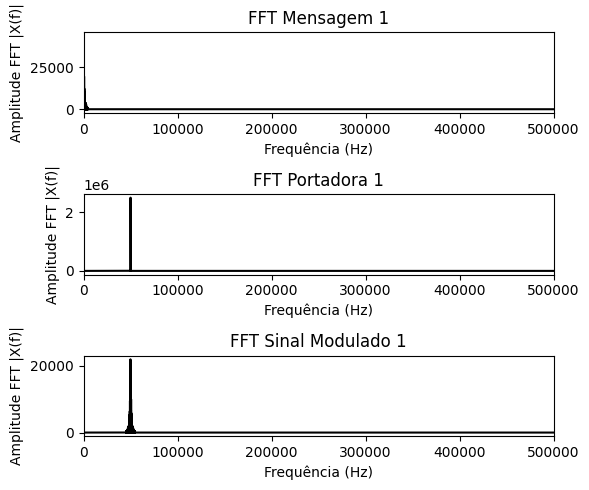

In [ ]:
# Obtenção da FFT da mensagem
fft_array_audio_1_superamostrado = np.fft.fft(array_audio_1_superamostrado)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_array_audio_1_superamostrado)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT da mensagem
plt.figure(figsize = (6, 5))
plt.subplot(3,1,1)
plt.plot(array_freq, np.abs(fft_array_audio_1_superamostrado), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Mensagem 1')

# Obtenção da FFT da portadora
fft_portadora_1 = np.fft.fft(portadora_1)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_portadora_1)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT da portadora
plt.subplot(3,1,2)
plt.plot(array_freq, np.abs(fft_portadora_1), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Portadora 1')

# Obtenção da FFT do sinal modulado
fft_mensagem_1_modulada = np.fft.fft(mensagem_1_modulada)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_mensagem_1_modulada)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT do sinal modulado
plt.subplot(3,1,3)
plt.plot(array_freq, np.abs(fft_mensagem_1_modulada), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Sinal Modulado 1')
plt.tight_layout()

**Modulação da segunda mensagem**

A seguir, são repetidos todos os passos para realizar a modulação de uma segunda mensagem, usando um $w_c$ diferente.

In [ ]:
# Endereço do arquivo de áudio 2
caminho_arquivo = librosa.ex('trumpet')
# Leitura do arquivo como um array numpy considerando a taxa de amostragem original do arquivo
array_audio_2, taxa_amostragem_2 = librosa.load(caminho_arquivo, sr=None)

# Retirando um trecho de 5 segundos do áudio
amostras_5s = 5 * taxa_amostragem_2
array_audio_2_cortado=array_audio_2[0:amostras_5s]

# Executando o sinal de áudio
Audio(data=array_audio_2_cortado, rate=taxa_amostragem_2)

In [ ]:
array_audio_2_subamostrado = librosa.resample(array_audio_2_cortado, orig_sr=taxa_amostragem_2, target_sr=freq_subamostragem)
# Reamostrando o áudio para a frequência mais alta
array_audio_2_superamostrado = librosa.resample(array_audio_2_subamostrado, orig_sr=freq_subamostragem, target_sr=freq_superamostragem)

# Frequência da portadora da rádio 2 [Hz]
fc2 = 10e4

# Criando a portadora 2
eixo_t=np.linspace(0, 5, len(array_audio_2_superamostrado))
portadora_2=np.zeros([len(array_audio_2_superamostrado)])
for i in range(0,len(array_audio_2_superamostrado)):
    portadora_2[i]=np.cos(2*np.pi*fc2*eixo_t[i])

# Realizando a modulação
mensagem_2_modulada=array_audio_2_superamostrado*portadora_2

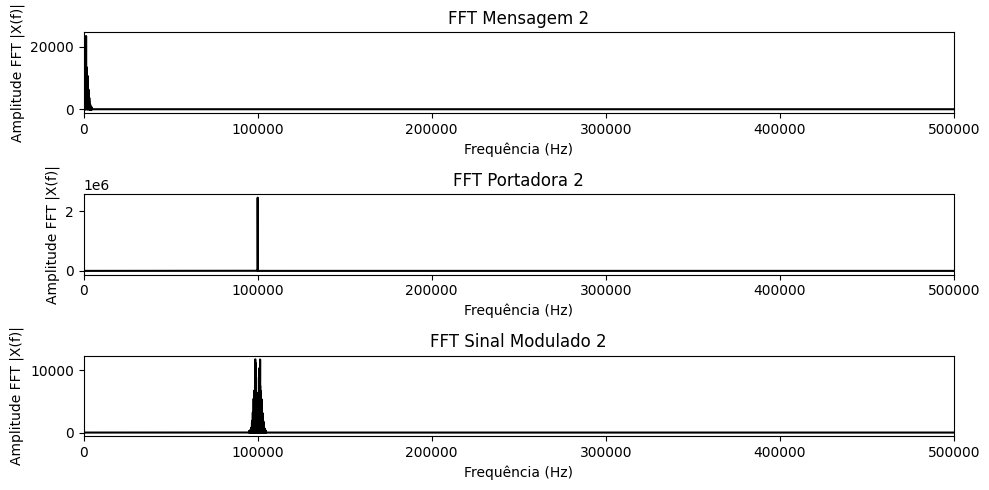

In [ ]:
# Obtenção da FFT da mensagem
fft_array_audio_2_superamostrado = np.fft.fft(array_audio_2_superamostrado)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_array_audio_2_superamostrado)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT da mensagem
plt.figure(figsize = (10, 5))
plt.subplot(3,1,1)
plt.plot(array_freq, np.abs(fft_array_audio_2_superamostrado), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Mensagem 2')

# Obtenção da FFT da portadora
fft_portadora_2 = np.fft.fft(portadora_2)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_portadora_2)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT da portadora
plt.subplot(3,1,2)
plt.plot(array_freq, np.abs(fft_portadora_2), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Portadora 2')

# Obtenção da FFT do sinal modulado
fft_mensagem_2_modulada = np.fft.fft(mensagem_2_modulada)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_mensagem_2_modulada)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT do sinal modulado
plt.subplot(3,1,3)
plt.plot(array_freq, np.abs(fft_mensagem_2_modulada), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Sinal Modulado 2')
plt.tight_layout()

**Criação do canal**

Nesta etapa, os sinais modulados são somados para simular a transmissão em um canal compartilhado ideal. Podemos vizualizar o resultado do compartilhamento do canal utilizando o gráfico do sinal no domínio do tempo e sua Transformada de Fourier. No domínio do tempo os sinais foram misturados, parecendo serem indicerníveis. Porém, no domínio da Transformadade Fourier, as componentes estão separadas, sendo possível recuperar os sinais por meio de um processo de demodulação.

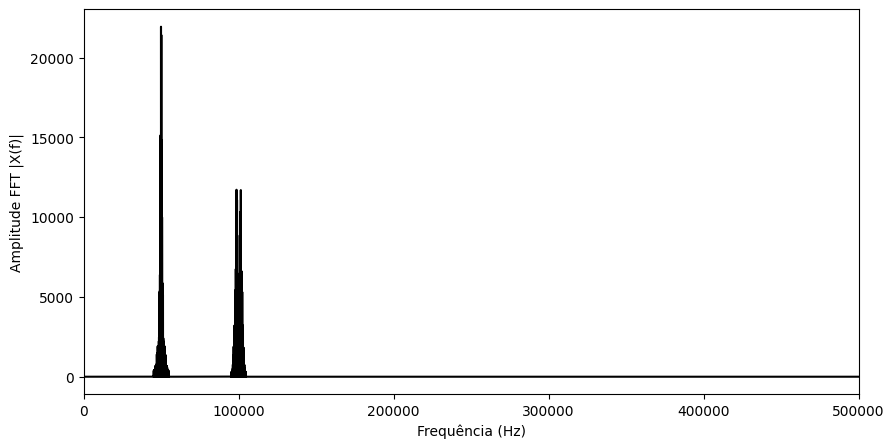

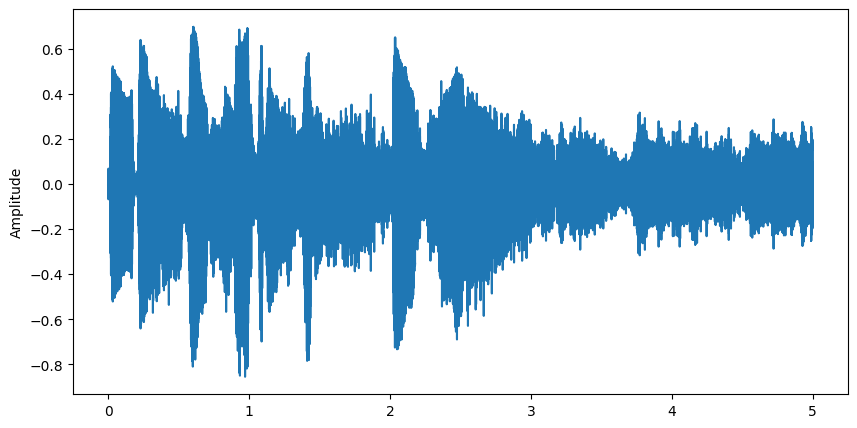

In [ ]:
canal=mensagem_1_modulada+mensagem_2_modulada

# Obtenção da FFT da mensagem
fft_canal = np.fft.fft(canal)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_canal)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT da mensagem
plt.figure(figsize = (10, 5))
plt.plot(array_freq, np.abs(fft_canal), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)

# Plotando o sinal de áudio
plt.figure(figsize = (10, 5))
plt.plot(eixo_t,canal)
plt.ylabel('Amplitude')


array_audio_canal = librosa.resample(canal, orig_sr=freq_superamostragem, target_sr=taxa_amostragem_1)
# Executando o sinal de áudio
Audio(data=array_audio_canal, rate=taxa_amostragem_1)

**Demodulação Síncrona**

Nesta etapa é realizada a demodulação da mensagem 1. Para tal, utilizaremos o método de demodulação síncrona, no qual, o sinal do canal é multiplicado por uma portadora, com frequência igual à da portadora usada na modulação, e é posteriormente filtrado utilizando um filtro passa-baixas. Essa filtragem é usada para recuperar apenas o conteúdo da mensagem desejada, sendo que o filtro é projetado com frequência de corte igual à largura de banda da mensagem. A seguir é apresentado este processo.


In [ ]:
# Multiplicação pela portadora
sinal_demodulado_1=canal*portadora_1

# Parâmetros do filtro
freq_corte=10000
ordem=2
tipo_filt='low'
# Instanciação do filtro
b, a = butter(ordem, freq_corte, btype=tipo_filt, analog=False, output='ba', fs=freq_superamostragem)
# Execução da filtragem
sinal_demodulado_1_filtrado = filtfilt(b, a, sinal_demodulado_1)


array_audio_demodulado_1 = librosa.resample(sinal_demodulado_1_filtrado, orig_sr=freq_superamostragem, target_sr=taxa_amostragem_1)
# Executando o sinal de áudio
Audio(data=array_audio_demodulado_1, rate=taxa_amostragem_1)

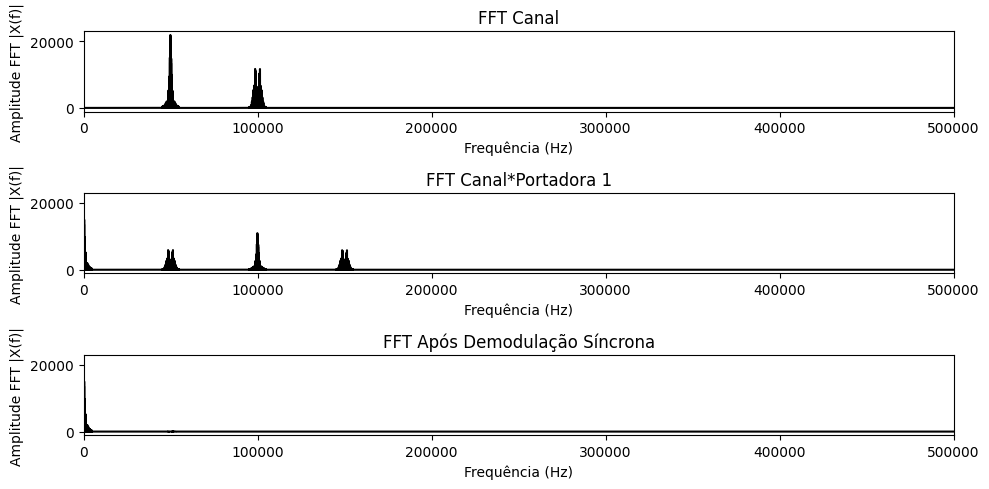

In [ ]:
# Plotando os coeficientes da FFT do canal
plt.figure(figsize = (10, 5))
plt.subplot(3,1,1)
plt.plot(array_freq, np.abs(fft_canal), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Canal')

# Obtenção da FFT do canal multiplicado pela portadora 1
fft_canal_m_portadora_1 = np.fft.fft(sinal_demodulado_1)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_canal_m_portadora_1)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT do canal multiplicado pela portadora 1
plt.subplot(3,1,2)
plt.plot(array_freq, np.abs(fft_canal_m_portadora_1), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Canal*Portadora 1')

# Obtenção da FFT do sinal demodulado
fft_demodulado_1 = np.fft.fft(sinal_demodulado_1_filtrado)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_demodulado_1)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT da mensagem demodulada
plt.subplot(3,1,3)
plt.plot(array_freq, np.abs(fft_demodulado_1), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Após Demodulação Síncrona')
plt.tight_layout()

# **Atividade**

Na demonstração que foi apresentada, as mensagens foram moduladas utilizando o processo de modulação AM-DSB-SC, ou seja, modulação em amplitude com portadora suprimida. Neste tipo de modulação, a portadora não é transmitida junto da mensagem modulada, e uma das consequências é não ser possível utilizar um circuito detector de envoltória. Para podermos utilizar um detector de envoltória, a modulação usada é a AM-DSB, na qual transmitimos junto à mensagem uma cópia da portadora. Essa modulação é representada pela equação

$$\Phi_{AM-DSB}(t)=[A+m(t)]cos(\omega_c t).$$

A constante $A$ define a amplitude da portadora e deve ser escolhida de forma a garantir que toda a porção negativa da mensagem seja deslocada e se torne positiva, fazendo com que a envoltória do sinal modulado seja a mensagem.

Se quisermos realizar a demodulação por detecção de envoltória, o primeiro passo consiste em utilizar o filtro passa-faixas, de forma a extrair do canal a porção do espectro associada à menságem que queremos demodular. Em seguida, podemos aplicar o detector de envoltória, o qual é composto por retificador do sinal, filtro passa-baixas e bloqueador de valor DC.

Nesta atividade o objetivo é desenvolver a simulação do processo de modulalção AM-DSB e o processo de demodulação por detecção de envoltória, vizualizando os passos necessários. Dessa forma, desenvolva as seguintes tarefas:

1.   Simule o processo de modulação AM-DSB utilizando dois sinais de áudio, modulados com duas portadoras distintas, escolhendo um fator de modulação adequado para detecção de envoltória;
2.   Mostre os espectros de cada etapa do processo de modulação, discutindo o objetivo de cada etapa;
3.   Simule o processo de demodulação por detecção de envoltória, aplicando o filtro passa-faixas, retificador, filtro passa-baixas e bloqueador de valor DC;
4.   Mostre os espectros de cada etapa do processo de demodulação, discutindo o objetivo de cada etapa;







In [3]:
# Endereço do arquivo de áudio 2
caminho_arquivo = librosa.ex('trumpet')
# Leitura do arquivo como um array numpy considerando a taxa de amostragem original do arquivo
array_audio_2, taxa_amostragem_2 = librosa.load(caminho_arquivo, sr=None)

caminho_arquivo = librosa.ex('vibeace')
# Leitura do arquivo como um array numpy considerando a taxa de amostragem original do arquivo
array_audio_1, taxa_amostragem_1 = librosa.load(caminho_arquivo, sr=None)

# Retirando um trecho de 5 segundos do áudio
amostras_5s = 5 * taxa_amostragem_2
array_audio_2_cortado=array_audio_2[0:amostras_5s]

amostras_5s = 5 * taxa_amostragem_1
array_audio_1_cortado=array_audio_1[0:amostras_5s]

# Executando o sinal de áudio
Audio(data=array_audio_1_cortado, rate=taxa_amostragem_1)

In [ ]:
Audio(data=array_audio_2_cortado, rate=taxa_amostragem_2)

In [4]:

# Definindo a frequência de amostragem para simular a trasmissão como se tivessemos usando um sistema contínuo
freq_superamostragem = 1e6
freq_subamostragem = 1e4

array_audio_2_subamostrado = librosa.resample(array_audio_2_cortado, orig_sr=taxa_amostragem_2, target_sr=freq_subamostragem)
# Reamostrando o áudio para a frequência mais alta
array_audio_2_superamostrado = librosa.resample(array_audio_2_subamostrado, orig_sr=freq_subamostragem, target_sr=freq_superamostragem)

array_audio_1_subamostrado = librosa.resample(array_audio_1_cortado, orig_sr=taxa_amostragem_1, target_sr=freq_subamostragem)
array_audio_1_superamostrado = librosa.resample(array_audio_1_subamostrado, orig_sr=freq_subamostragem, target_sr=freq_superamostragem)

# Frequência da portadora da rádio 2 [Hz]
fc2 = 10e4
fc1 = 125e3

# Criando a portadora 1
eixo_t1=np.linspace(0, 5, len(array_audio_1_superamostrado))
portadora_1=np.zeros([len(array_audio_1_superamostrado)])
for i in range(0,len(array_audio_1_superamostrado)):
    portadora_1[i]=np.cos(2*np.pi*fc1*eixo_t1[i])

# Criando a portadora 2
eixo_t=np.linspace(0, 5, len(array_audio_2_superamostrado))
portadora_2=np.zeros([len(array_audio_2_superamostrado)])
for i in range(0,len(array_audio_2_superamostrado)):
    portadora_2[i]=np.cos(2*np.pi*fc2*eixo_t[i])


Text(0.5, 1.0, 'FFT Mensagems moduladas')

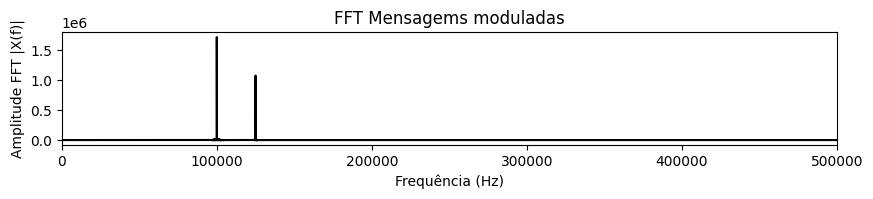

In [6]:

# mp ( valor máximo em modulo , fator de modulação = 1
A = max(abs(array_audio_2_superamostrado))
A1 = max(abs(array_audio_1_superamostrado))

mensagem_2_modulada = (array_audio_2_superamostrado + A) * portadora_2 # msg2 modulada
mensagem_1_modulada = (array_audio_1_superamostrado + A1) * portadora_1 # msg1 modulada

mensagems_moduladas = mensagem_1_modulada + mensagem_2_modulada

# Obtenção da FFT da mensagem
fft_mensagems_moduladas = np.fft.fft(mensagems_moduladas)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_mensagems_moduladas)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT da mensagem
plt.figure(figsize = (10, 5))
plt.subplot(3,1,1)
plt.plot(array_freq, np.abs(fft_mensagems_moduladas), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Mensagems moduladas')


(2.6, 2.601)

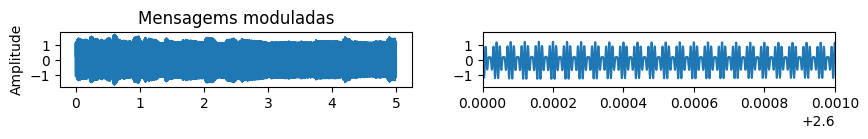

In [7]:

# Plotando o sinal de áudio
plt.figure(figsize = (10, 5))
plt.subplot(6,2,1)
plt.plot(eixo_t,mensagems_moduladas)
plt.ylabel('Amplitude')
plt.title('Mensagems moduladas')

plt.subplot(6,2,2)
plt.plot(eixo_t,mensagems_moduladas)
plt.xlim(2.6,2.601)


Text(0.5, 1.0, 'FFT Mensagems moduladas')

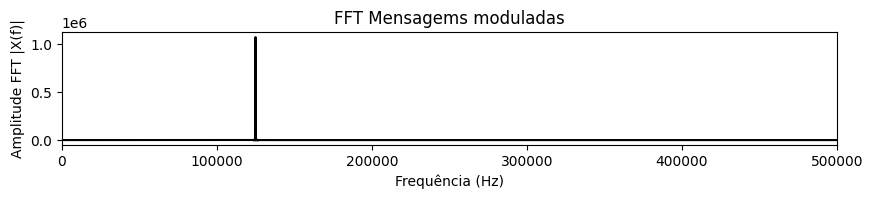

In [8]:

ordem=4
B=5e3
low=fc1 - B
high=fc1 + B
tipo_filt='band'

# Mensagem filtrada com largura de banda = B, onde a
# frequência da portadora é igual a fcX
b, a = butter(ordem, [low, high], btype=tipo_filt, analog=False, output='ba', fs=freq_superamostragem)
mensagem_filtrada1 = filtfilt(b, a, mensagems_moduladas)

# Obtenção da FFT da mensagem
fft_mensagem_filtrada = np.fft.fft(mensagem_filtrada1)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_mensagem_filtrada)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT da mensagem
plt.figure(figsize = (10, 5))
plt.subplot(3,1,1)
plt.plot(array_freq, np.abs(fft_mensagem_filtrada), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Mensagems moduladas')


Text(0.5, 1.0, 'FFT Mensagems moduladas')

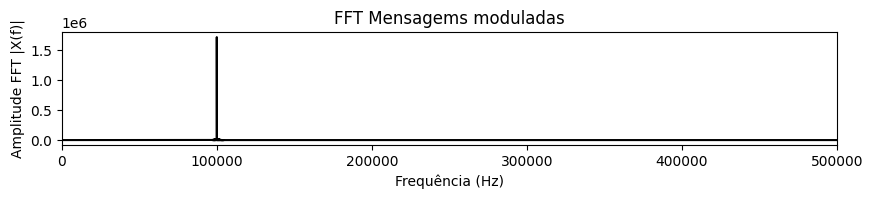

In [9]:

ordem=4
B=5e3
low=fc2 - B
high=fc2 + B
tipo_filt='band'

# Mensagem filtrada com largura de banda = B, onde a
# frequência da portadora é igual a fcX
b, a = butter(ordem, [low, high], btype=tipo_filt, analog=False, output='ba', fs=freq_superamostragem)
mensagem_filtrada2 = filtfilt(b, a, mensagems_moduladas)

# Obtenção da FFT da mensagem
fft_mensagem_filtrada = np.fft.fft(mensagem_filtrada2)
# Criação do array com frequências para plotar os coeficientes
N = len(fft_mensagem_filtrada)
n = np.arange(N)
T = N/freq_superamostragem
array_freq = n/T

# Plotando os coeficientes da FFT da mensagem
plt.figure(figsize = (10, 5))
plt.subplot(3,1,1)
plt.plot(array_freq, np.abs(fft_mensagem_filtrada), 'k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude FFT |X(f)|')
plt.xlim(0, freq_superamostragem/2)
plt.title('FFT Mensagems moduladas')


In [10]:

# Envelope detection
#envelope_ = envelope(mensagem_filtrada, residual=None)

# Retificação
mensagem_retificada = abs(mensagem_filtrada1)

ordem=4
freq_corte=35e3
tipo_filt='low'

# Filtro passa baixas
b, a = butter(ordem, freq_corte, btype=tipo_filt, analog=False, output='ba', fs=freq_superamostragem)
mensagem_sem_residual = filtfilt(b, a, mensagem_retificada)

# Remove DC Value
mensagem_normalizada = mensagem_sem_residual - np.mean(mensagem_sem_residual)

array_demod = librosa.resample(mensagem_normalizada, orig_sr=freq_superamostragem, target_sr=taxa_amostragem_2)

# Slice audio
audio_mensagem_demodulada = array_demod[:int(5 * taxa_amostragem_2)]

# Play
Audio(data=audio_mensagem_demodulada, rate=taxa_amostragem_2)

In [11]:
# Retificação
mensagem_retificada = abs(mensagem_filtrada2)

ordem=4
freq_corte=35e3
tipo_filt='low'

# Filtro passa baixas
b, a = butter(ordem, freq_corte, btype=tipo_filt, analog=False, output='ba', fs=freq_superamostragem)
mensagem_sem_residual = filtfilt(b, a, mensagem_retificada)

# Remove DC Value
mensagem_normalizada = mensagem_sem_residual - np.mean(mensagem_sem_residual)

array_demod = librosa.resample(mensagem_normalizada, orig_sr=freq_superamostragem, target_sr=taxa_amostragem_2)

# Slice audio
audio_mensagem_demodulada = array_demod[:int(5 * taxa_amostragem_2)]

# Play
Audio(data=audio_mensagem_demodulada, rate=taxa_amostragem_2)